In [12]:
import pymc as pm
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [3]:
class Bandits(object):
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(self.p)
    
    def pull(self, i):
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

In [10]:
class BayesianStrategy(object):
    
    def __init__(self, bandits):
        self.bandits = bandits
        self.wins = np.zeros(len(self.bandits))
        self.trials = np.zeros(len(self.bandits))
        self.choices = []
        self.bb_score = []
    
    def sample_bandits(self, n=1):        
        for k in range(n):
            choice = np.argmax(ss.beta.rvs(1 + self.wins, 1 + self.trials - self.wins))
            result = self.bandits.pull(choice)
            self.bb_score.append(result)
            self.choices.append(choice)
            self.wins[choice] += result
            self.trials[choice] += 1
    
    @property
    def N(self):
        return self.trials.sum()

In [19]:
def plot_priors(strategy: BayesianStrategy, probs, lw=3, alpha=0.2, plt_vlines=True):
    wins, trials, N = strategy.wins, strategy.trials, strategy.N
    x = np.linspace(0.01, 0.999, 200)
    for i in range(len(strategy.bandits)):
        # 每个老虎机的后验分布
        distr = ss.beta(1 + wins[i], 1 + trials[i] - wins[i])
        y = distr.pdf(x)
        p = plt.plot(x, y, lw=lw, label=f"Hidden {probs[i]}")
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y, 0, color=c, alpha=alpha)
        if plt_vlines:
            plt.vlines(probs[i], 0, distr.pdf(probs[i]), color=c, linestyles="--", lw=2)
        plt.autoscale(tight=True)
    plt.legend(loc="upper left")

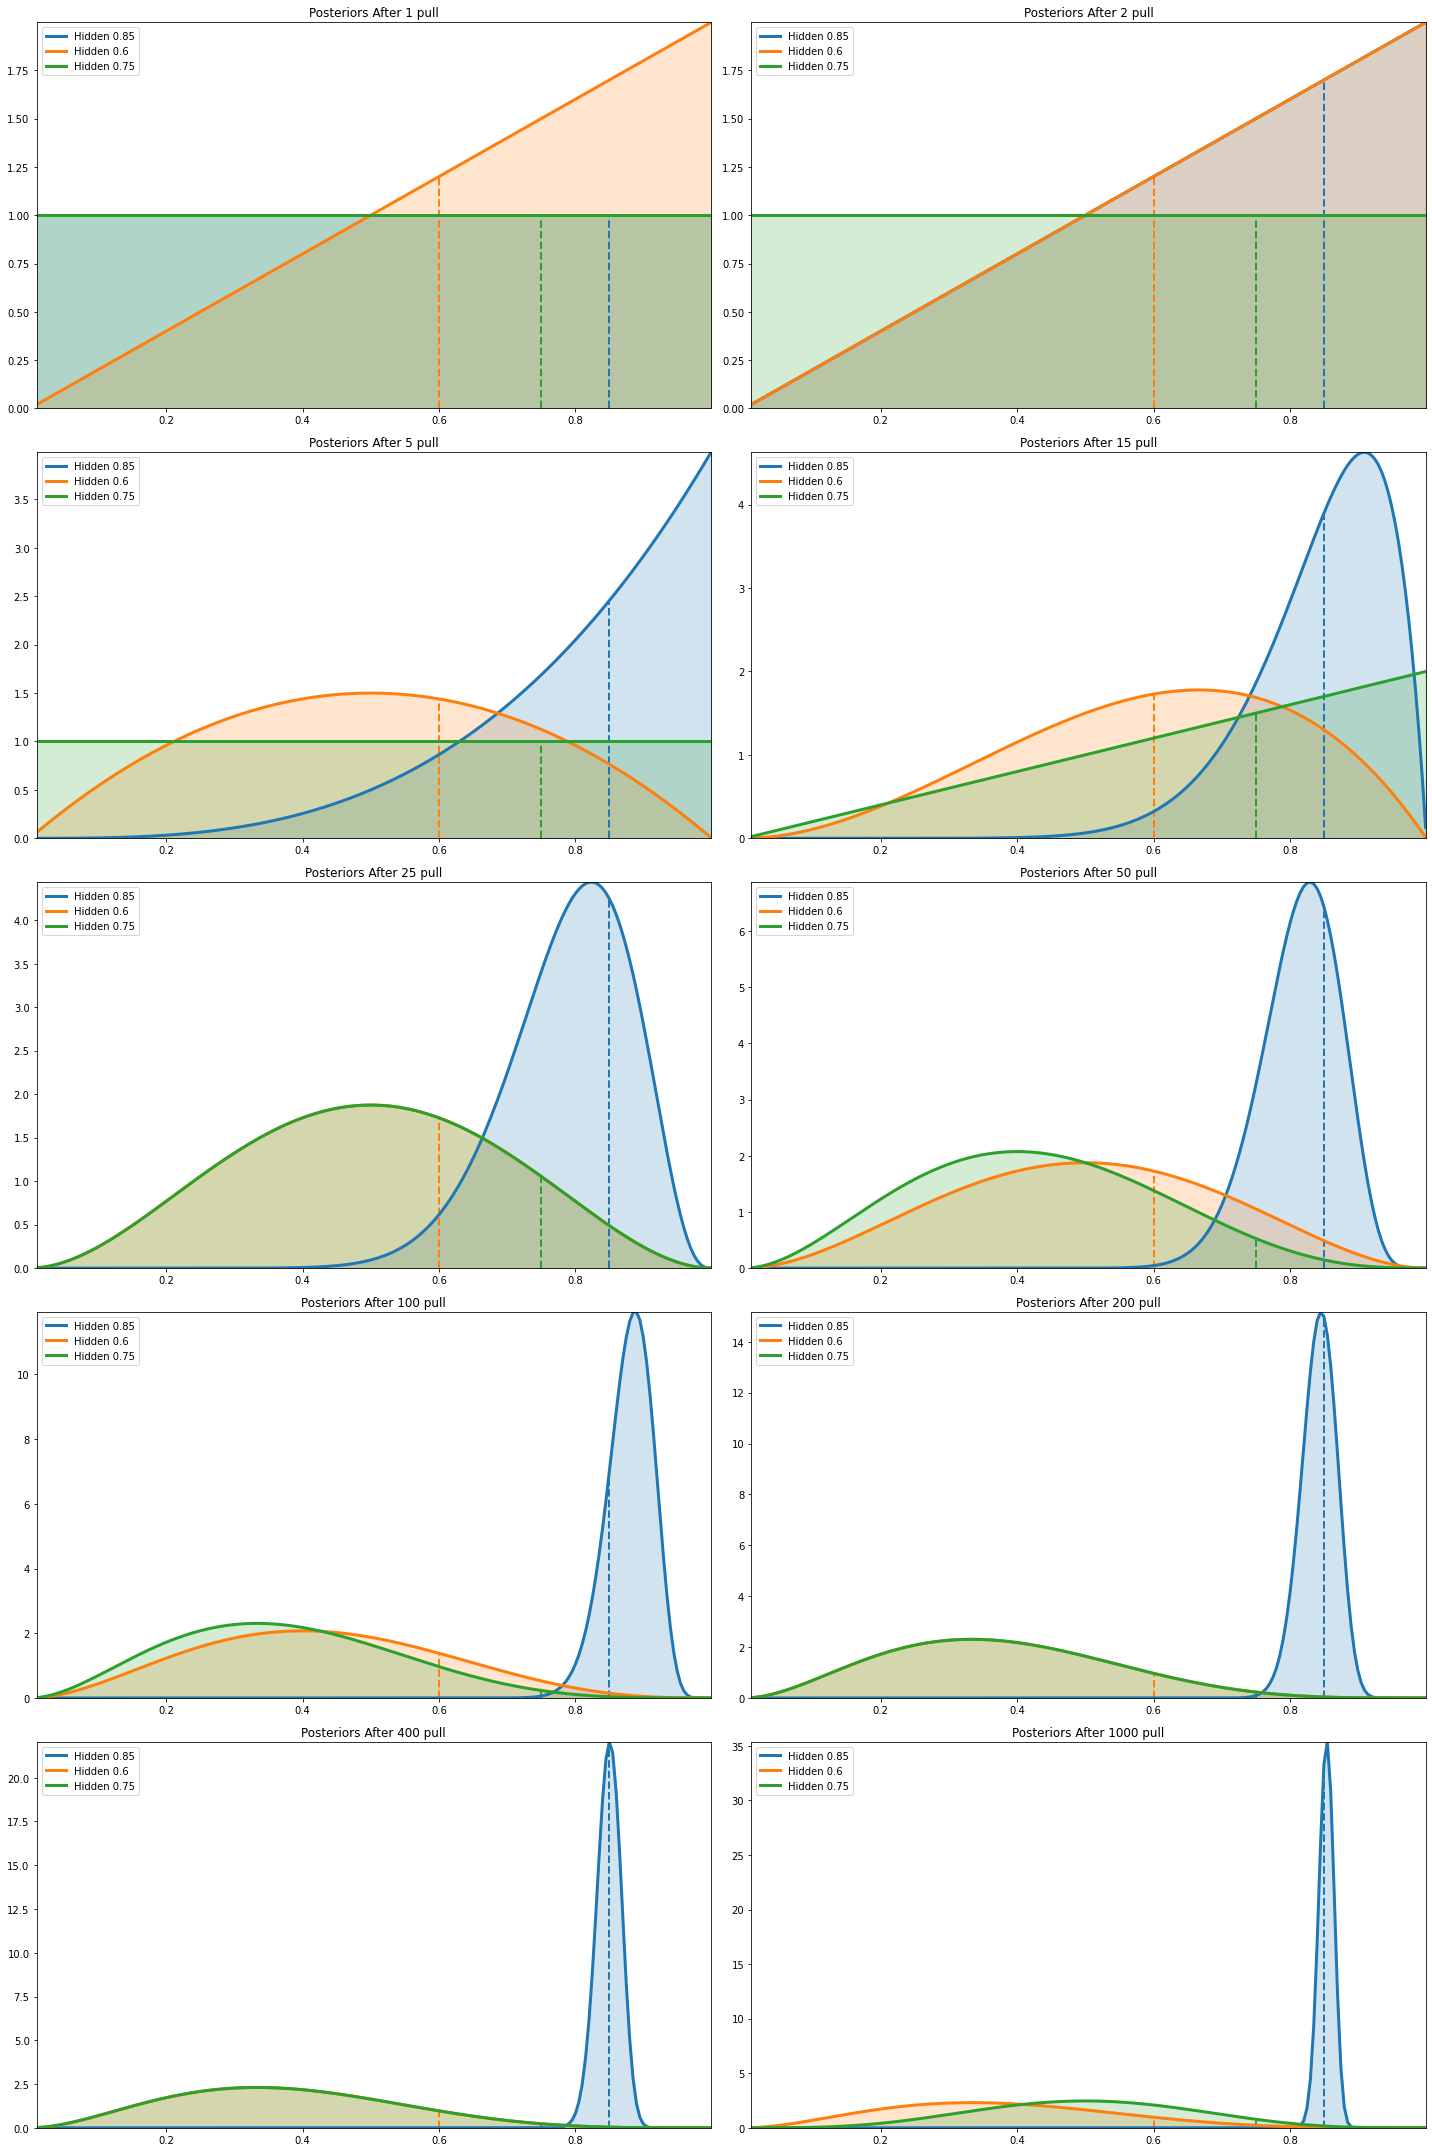

In [20]:
hidden_probs = [0.85, 0.6, 0.75]
bandits = Bandits(hidden_probs)
strategy = BayesianStrategy(bandits)
step_samples = [1, 2, 5, 15, 25, 50, 100, 200, 400, 1000]


plt.figure(figsize=(20, 30))
for i, step in enumerate(step_samples):
    plt.subplot(5, 2, i + 1)
    strategy.sample_bandits(step - strategy.N)  # 实验至需要的步数
    plot_priors(strategy, hidden_probs)
    plt.title(f"Posteriors After {step} pull")
plt.tight_layout()